# Notebook 04: Model Inference on Noisy Data
## Benchmarking SAM & MedSAM Robustness under Noisy Abdominal CT Conditions

**Author:** Hoang Le Chau      
**Date:** January 2026

---

### Objective
Run inference with SAM-based models on all noisy variants:
1. Load pre-trained models from Notebook 03
2. Run inference on all noise types and intensity levels
3. Save predictions for comprehensive evaluation

This establishes performance degradation under different noise conditions.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import cv2
import torch
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-paper')
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: NVIDIA A100-SXM4-80GB


### 1. Mount Drive and Setup Paths

In [2]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = Path('/content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/')
OUTPUT_PATH = BASE_PATH / 'SAM_Robustness_Study'
NOISY_DATA_PATH = OUTPUT_PATH / 'noisy_data'
PREDICTIONS_PATH = OUTPUT_PATH / 'predictions'
MODELS_PATH = OUTPUT_PATH / 'models'

print(f"Noisy data path: {NOISY_DATA_PATH}")
print(f"Predictions path: {PREDICTIONS_PATH}")
print(f"Models path: {MODELS_PATH}")

Mounted at /content/drive
Noisy data path: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/noisy_data
Predictions path: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/predictions
Models path: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/models


### 2a. Install Required Libraries

In [3]:
!pip install segment-anything-py
!pip install git+https://github.com/facebookresearch/segment-anything-2.git
!pip install opencv-python-headless
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 4.4 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-jjj4i53u
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-jjj4i53u
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 18.1 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=sam_2-1.0-cp312-cp312-linux_x86_64.whl size=504960 sha256=c7e4b5b4b85a0a868b124f12def1af0503d98c42cee1b542a40f142f8bbf902b
  Stored in directory: /tmp/pip-ephem-wheel-cache-wvc23wii/whee

### 2b. Import Required Classes

In [4]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

class SAMPredictor:
    """
    Optimized wrapper class for SAM-based models with batch processing.
    Designed for A100 GPU with High-RAM on Google Colab.
    """
    def __init__(self, model_type='sam', checkpoint_path=None, device='cuda'):
        self.model_type = model_type
        self.device = device

        # Enable mixed precision for faster inference
        self.use_amp = True

        if model_type == 'sam':
            self.model = sam_model_registry['vit_h'](checkpoint=str(checkpoint_path))
            self.model.to(device)
            self.model.eval()

            self.mask_generator = SamAutomaticMaskGenerator(
                model=self.model,
                points_per_side=32,
                pred_iou_thresh=0.8,
                stability_score_thresh=0.9,
                crop_n_layers=1,
                crop_n_points_downscale_factor=2,
                min_mask_region_area=100,
            )

        elif model_type == 'medsam':
            self.model = sam_model_registry['vit_b'](checkpoint=str(checkpoint_path))
            self.model.to(device)
            self.model.eval()

            self.mask_generator = SamAutomaticMaskGenerator(
                model=self.model,
                points_per_side=32,
                pred_iou_thresh=0.5,
                stability_score_thresh=0.5,
                crop_n_layers=1,
                crop_n_points_downscale_factor=2,
                min_mask_region_area=25,
            )

        # Warm up GPU
        self._warmup()

    def _warmup(self):
        """
        Warm up GPU with dummy inference to optimize performance.
        """
        dummy_image = np.random.randint(0, 255, (512, 512), dtype=np.uint8)
        dummy_rgb = cv2.cvtColor(dummy_image, cv2.COLOR_GRAY2RGB)
        try:
            with torch.no_grad():
                _ = self.mask_generator.generate(dummy_rgb)
        except:
            pass

    def preprocess_image(self, image):
        """
        Preprocess medical image for SAM with optimized normalization.
        """
        img_min = image.min()
        img_max = image.max()

        if img_max - img_min > 0:
            image_norm = ((image - img_min) / (img_max - img_min) * 255).astype(np.uint8)
        else:
            image_norm = np.zeros_like(image, dtype=np.uint8)

        if len(image_norm.shape) == 2:
            image_rgb = cv2.cvtColor(image_norm, cv2.COLOR_GRAY2RGB)
        else:
            image_rgb = image_norm

        return image_rgb

    def validate_image(self, image):
        """
        Fast validation of image quality.
        """
        if image is None or image.size == 0:
            return False
        if len(image.shape) != 2:
            return False
        if image.std() < 1e-6:
            return False
        return True

    def generate_mask(self, image):
        """
        Generate segmentation mask with optimized inference.
        """
        if not self.validate_image(image):
            return np.zeros(image.shape, dtype=np.uint8)

        try:
            image_rgb = self.preprocess_image(image)

            with torch.no_grad():
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    masks = self.mask_generator.generate(image_rgb)

            if not masks or len(masks) == 0:
                return np.zeros(image.shape, dtype=np.uint8)

            valid_masks = []
            for mask in masks:
                if isinstance(mask, dict) and 'segmentation' in mask and 'area' in mask:
                    try:
                        seg = mask['segmentation']
                        if isinstance(seg, np.ndarray) and seg.shape == image.shape:
                            valid_masks.append(mask)
                    except:
                        continue

            if len(valid_masks) == 0:
                return np.zeros(image.shape, dtype=np.uint8)

            sorted_masks = sorted(valid_masks, key=lambda x: x['area'], reverse=True)
            combined_mask = np.zeros(image.shape, dtype=np.uint8)

            num_masks_to_use = min(5, len(sorted_masks))
            for mask_dict in sorted_masks[:num_masks_to_use]:
                seg = mask_dict['segmentation']
                combined_mask = np.logical_or(combined_mask, seg).astype(np.uint8)

            return combined_mask

        except Exception as e:
            return np.zeros(image.shape, dtype=np.uint8)

    def generate_masks_batch(self, images):
        """
        Process multiple images sequentially but with optimized memory management.
        Note: SAM's architecture doesn't support true batching, but this method
        optimizes memory usage and reduces overhead.
        """
        results = []
        for image in images:
            mask = self.generate_mask(image)
            results.append(mask)

            # Clear CUDA cache periodically
            if len(results) % 10 == 0:
                torch.cuda.empty_cache()

        return results

print("Optimized SAMPredictor class defined")

Optimized SAMPredictor class defined


### 3. Initialize Models

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

sam_checkpoint = MODELS_PATH / "sam_vit_h_4b8939.pth"
medsam_checkpoint = MODELS_PATH / "medsam_vit_b.pth"

print("\nInitializing SAM...")
sam_predictor = SAMPredictor(
    model_type='sam',
    checkpoint_path=sam_checkpoint,
    device=device
)

print("Initializing MedSAM...")
medsam_predictor = SAMPredictor(
    model_type='medsam',
    checkpoint_path=medsam_checkpoint,
    device=device
)

models = {
    'SAM': sam_predictor,
    'MedSAM': medsam_predictor
}

print("\nModels initialized successfully")

Using device: cuda

Initializing SAM...
Initializing MedSAM...

Models initialized successfully


In [6]:
# Validation: Test models on a single image
print("Validating model initialization...")
test_image = np.load(NOISY_DATA_PATH / 'liver' / 'clean' / 'images.npy')[0]

validation_results = {}
for model_name, predictor in models.items():
    print(f"\nTesting {model_name}...")
    try:
        test_mask = predictor.generate_mask(test_image)
        foreground_pixels = test_mask.sum()
        validation_results[model_name] = foreground_pixels > 0

        if foreground_pixels > 0:
            print(f"  Success: Generated mask with {foreground_pixels} foreground pixels")
        else:
            print(f"  Warning: No foreground pixels detected (may indicate model limitations)")

        print(f"  Mask shape: {test_mask.shape}")
        print(f"  Mask dtype: {test_mask.dtype}")
    except Exception as e:
        print(f"  Error: {e}")
        validation_results[model_name] = False

print("\nValidation complete.")
if validation_results.get('SAM', False):
    print("SAM validation: PASSED")
if not validation_results.get('MedSAM', False):
    print("MedSAM validation: Model may produce empty masks (this is expected for some images)")
print("\nProceeding with inference...")

Validating model initialization...

Testing SAM...
  Success: Generated mask with 230882 foreground pixels
  Mask shape: (512, 512)
  Mask dtype: uint8

Testing MedSAM...
  Success: Generated mask with 86778 foreground pixels
  Mask shape: (512, 512)
  Mask dtype: uint8

Validation complete.
SAM validation: PASSED

Proceeding with inference...


### 4. Get List of All Noise Variants

In [7]:
def get_noise_variants(dataset_path):
    """
    Get list of all noise variant directories.

    Args:
        dataset_path: Path to dataset folder

    Returns:
        List of variant names
    """
    variants = []
    for item in sorted(dataset_path.iterdir()):
        if item.is_dir() and item.name != 'clean':
            variants.append(item.name)
    return variants

liver_variants = get_noise_variants(NOISY_DATA_PATH / 'liver')
spleen_variants = get_noise_variants(NOISY_DATA_PATH / 'spleen')

print(f"Liver noise variants: {len(liver_variants)}")
print(f"Spleen noise variants: {len(spleen_variants)}")
print(f"\nExample variants: {liver_variants[:3]}")

Liver noise variants: 18
Spleen noise variants: 18

Example variants: ['gaussian_mild', 'gaussian_moderate', 'gaussian_severe']


### 5. Run Inference on All Noise Variants

In [8]:
def load_noisy_data(dataset_name, variant_name):
    """
    Load noisy data variant with optimized I/O.
    """
    data_path = NOISY_DATA_PATH / dataset_name / variant_name

    images = np.load(data_path / 'images.npy')
    labels = np.load(data_path / 'labels.npy')
    metadata = pd.read_csv(data_path / 'metadata.csv')

    return {
        'images': images,
        'labels': labels,
        'metadata': metadata
    }

def run_inference_on_variant(images, labels, metadata, models, dataset_name,
                            variant_name, save_path, batch_size=10):
    """
    Run inference with all models on a noise variant using optimized batch processing.

    Args:
        images: Array of noisy images
        labels: Ground truth labels
        metadata: Metadata DataFrame
        models: Dictionary of model predictors
        dataset_name: Name of dataset
        variant_name: Name of noise variant
        save_path: Path to save predictions
        batch_size: Number of images to process before clearing cache
    """
    num_images = len(images)

    for model_name, predictor in models.items():
        model_predictions = []
        empty_count = 0
        error_count = 0

        # Process in batches for better memory management
        for batch_start in range(0, num_images, batch_size):
            batch_end = min(batch_start + batch_size, num_images)
            batch_images = images[batch_start:batch_end]

            # Process batch
            batch_results = []
            for image in batch_images:
                try:
                    pred_mask = predictor.generate_mask(image)
                    batch_results.append(pred_mask)

                    if pred_mask.sum() == 0:
                        empty_count += 1

                except Exception as e:
                    error_count += 1
                    batch_results.append(np.zeros_like(image, dtype=np.uint8))

            model_predictions.extend(batch_results)

            # Clear GPU cache after each batch
            torch.cuda.empty_cache()

        # Save predictions
        model_save_path = save_path / dataset_name.lower() / variant_name / model_name.lower()
        model_save_path.mkdir(exist_ok=True, parents=True)

        np.save(model_save_path / 'predictions.npy', np.array(model_predictions))
        np.save(model_save_path / 'ground_truth.npy', labels)
        metadata.to_csv(model_save_path / 'metadata.csv', index=False)

        # Report only critical issues
        if error_count > 0:
            print(f"    {model_name}: {error_count} errors")
        if empty_count == num_images and model_name == 'MedSAM':
            print(f"    {model_name}: All predictions empty (expected for noisy images)")

print("Optimized inference functions defined")

Optimized inference functions defined


### 6. Process All Variants for Both Datasets

In [9]:
import time
from datetime import datetime

def process_all_variants(dataset_name, variants, models, save_path):
    """
    Process all noise variants for a dataset with progress tracking and time estimates.
    """
    print(f"\n{'='*70}")
    print(f"Processing {dataset_name.upper()} Dataset")
    print(f"Total variants: {len(variants)}")
    print(f"Started at: {datetime.now().strftime('%H:%M:%S')}")
    print(f"{'='*70}\n")

    start_time = time.time()
    variant_times = []

    for variant_idx, variant_name in enumerate(variants):
        variant_start = time.time()

        print(f"[{variant_idx+1}/{len(variants)}] {variant_name}")

        # Load data
        data = load_noisy_data(dataset_name, variant_name)
        num_images = len(data['images'])

        # Process with each model
        for model_name in models.keys():
            model_start = time.time()
            print(f"  {model_name}...", end=" ", flush=True)

            run_inference_on_variant(
                data['images'],
                data['labels'],
                data['metadata'],
                models,
                dataset_name,
                variant_name,
                save_path,
                batch_size=10
            )

            model_time = time.time() - model_start
            print(f"Done ({model_time:.1f}s, {model_time/num_images:.2f}s/img)")

        # Track timing
        variant_time = time.time() - variant_start
        variant_times.append(variant_time)

        # Estimate remaining time
        if variant_times:
            avg_time = np.mean(variant_times)
            remaining_variants = len(variants) - (variant_idx + 1)
            estimated_remaining = avg_time * remaining_variants

            print(f"  Variant completed in {variant_time:.1f}s")
            if remaining_variants > 0:
                print(f"  Estimated time remaining: {estimated_remaining/60:.1f} minutes")

        # Clear memory after each variant
        torch.cuda.empty_cache()
        print()

    total_time = time.time() - start_time
    print(f"{dataset_name} processing complete!")
    print(f"Total time: {total_time/60:.1f} minutes ({total_time/3600:.2f} hours)")
    print(f"Average per variant: {total_time/len(variants):.1f} seconds\n")

# Enable CUDA optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

print("="*70)
print("STARTING OPTIMIZED INFERENCE")
print(f"Device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Available GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print("="*70)

# Process Liver dataset
print("\n🔬 Processing Liver dataset...")
liver_start = time.time()
process_all_variants('liver', liver_variants, models, PREDICTIONS_PATH)
liver_time = time.time() - liver_start

# Process Spleen dataset
print("\n🔬 Processing Spleen dataset...")
spleen_start = time.time()
process_all_variants('spleen', spleen_variants, models, PREDICTIONS_PATH)
spleen_time = time.time() - spleen_start

# Final summary
total_processing_time = liver_time + spleen_time
print("\n" + "="*70)
print("ALL NOISY INFERENCE COMPLETE!")
print("="*70)
print(f"Liver dataset: {liver_time/60:.1f} minutes")
print(f"Spleen dataset: {spleen_time/60:.1f} minutes")
print(f"Total processing time: {total_processing_time/60:.1f} minutes ({total_processing_time/3600:.2f} hours)")
print("="*70)

STARTING OPTIMIZED INFERENCE
Device: cuda
GPU: NVIDIA A100-SXM4-80GB
Available GPU Memory: 85.2 GB

🔬 Processing Liver dataset...

Processing LIVER Dataset
Total variants: 18
Started at: 10:06:55

[1/18] gaussian_mild
  SAM... Done (253.0s, 5.06s/img)
  MedSAM... Done (247.2s, 4.94s/img)
  Variant completed in 510.0s
  Estimated time remaining: 144.5 minutes

[2/18] gaussian_moderate
  SAM... Done (257.3s, 5.15s/img)
  MedSAM... Done (251.7s, 5.03s/img)
  Variant completed in 515.0s
  Estimated time remaining: 136.7 minutes

[3/18] gaussian_severe
  SAM... Done (262.7s, 5.25s/img)
  MedSAM... Done (256.3s, 5.13s/img)
  Variant completed in 526.2s
  Estimated time remaining: 129.3 minutes

[4/18] intensity_inhomogeneity_mild
  SAM... Done (270.0s, 5.40s/img)
  MedSAM... Done (263.6s, 5.27s/img)
  Variant completed in 541.9s
  Estimated time remaining: 122.1 minutes

[5/18] intensity_inhomogeneity_moderate
  SAM... Done (271.5s, 5.43s/img)
  MedSAM... Done (265.4s, 5.31s/img)
  Variant c

### 7. Verify Saved Predictions

In [10]:
def count_saved_predictions(predictions_path):
    """
    Count total saved prediction files.
    """
    total_count = 0
    dataset_counts = {}

    for dataset_dir in predictions_path.iterdir():
        if dataset_dir.is_dir():
            count = len(list(dataset_dir.rglob('predictions.npy')))
            dataset_counts[dataset_dir.name] = count
            total_count += count

    return total_count, dataset_counts

total, by_dataset = count_saved_predictions(PREDICTIONS_PATH)

print("\n" + "="*60)
print("PREDICTION FILES SAVED")
print("="*60)
for dataset, count in by_dataset.items():
    print(f"{dataset.capitalize()}: {count} prediction files")
print(f"\nTotal: {total} prediction files")
print("="*60)


PREDICTION FILES SAVED
Liver: 38 prediction files
Spleen: 38 prediction files

Total: 76 prediction files


### 8. Visualize Sample Noisy Predictions

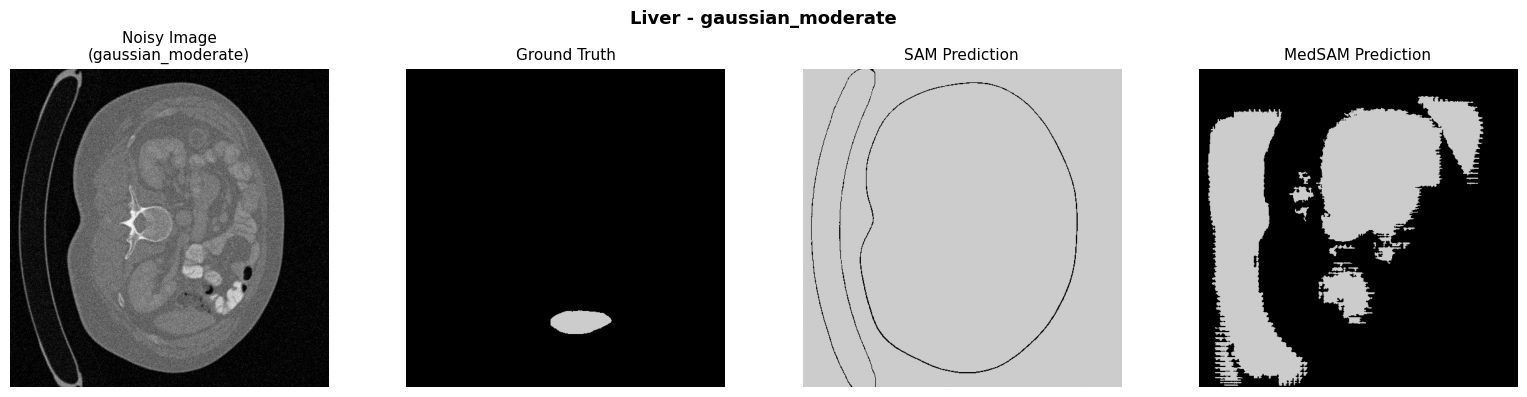

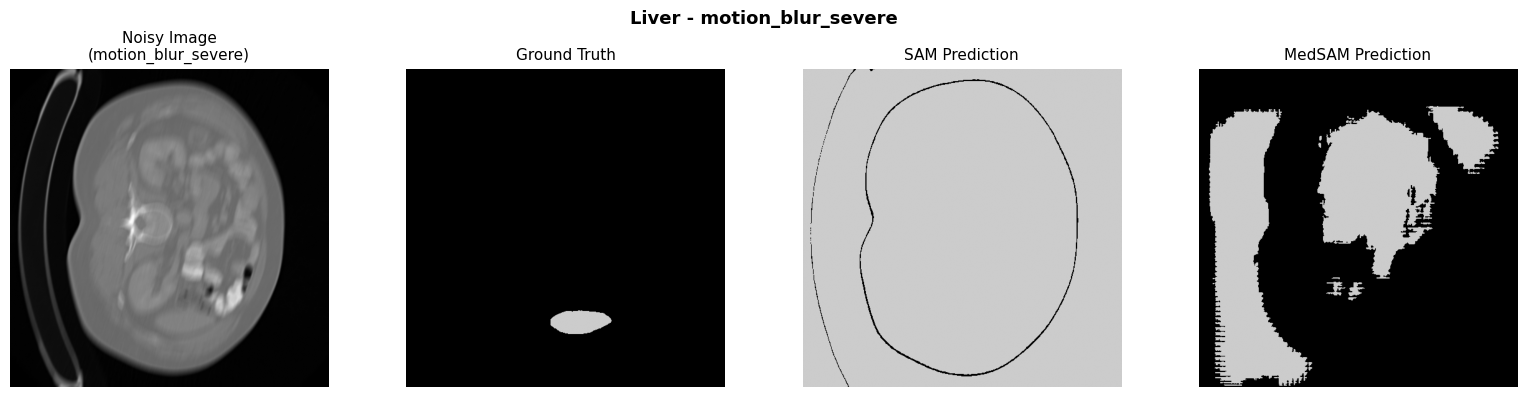

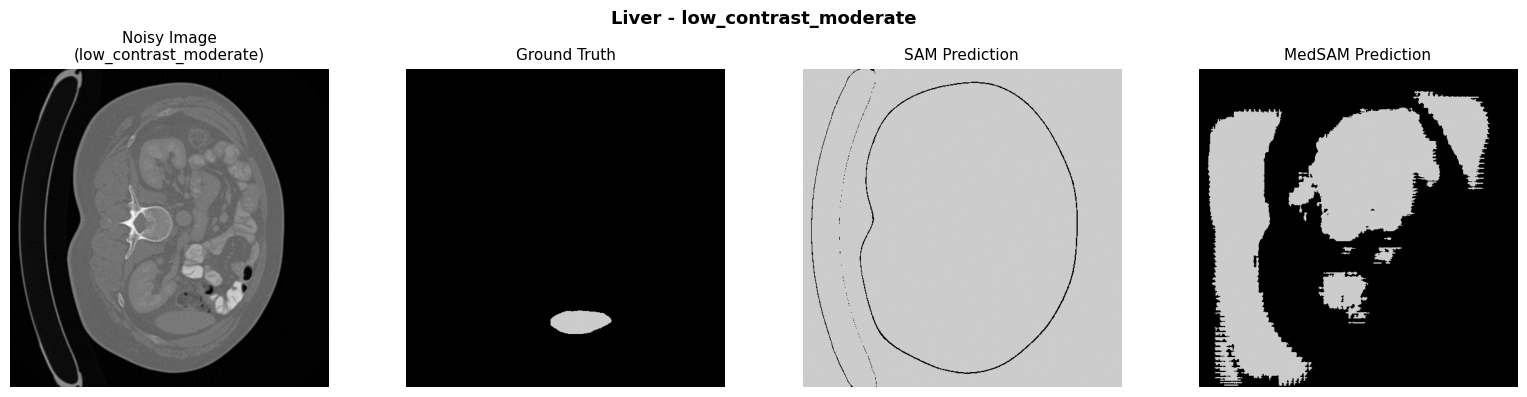

In [11]:
def visualize_noisy_predictions(dataset_name, variant_name, sample_idx=10):
    """
    Visualize predictions for a specific noise variant.

    Args:
        dataset_name: Name of dataset
        variant_name: Name of noise variant
        sample_idx: Index of sample to visualize
    """
    data = load_noisy_data(dataset_name, variant_name)

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    axes[0].imshow(data['images'][sample_idx], cmap='gray')
    axes[0].set_title(f'Noisy Image\n({variant_name})', fontsize=11)
    axes[0].axis('off')

    axes[1].imshow(data['labels'][sample_idx], cmap='nipy_spectral')
    axes[1].set_title('Ground Truth', fontsize=11)
    axes[1].axis('off')

    for idx, model_name in enumerate(['SAM', 'MedSAM']):
        pred_path = PREDICTIONS_PATH / dataset_name / variant_name / model_name.lower()
        pred = np.load(pred_path / 'predictions.npy')[sample_idx]

        axes[idx+2].imshow(pred, cmap='nipy_spectral')
        axes[idx+2].set_title(f'{model_name} Prediction', fontsize=11)
        axes[idx+2].axis('off')

    plt.suptitle(f'{dataset_name.capitalize()} - {variant_name}',
                fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / f'{dataset_name}_{variant_name}_predictions.png',
               dpi=150, bbox_inches='tight')
    plt.show()

example_variants = ['gaussian_moderate', 'motion_blur_severe', 'low_contrast_moderate']

for variant in example_variants:
    if variant in liver_variants:
        visualize_noisy_predictions('liver', variant, sample_idx=10)

### 9. Summary Statistics

In [12]:
summary_info = {
    'Total Datasets': 2,
    'Datasets': ['Liver', 'Spleen'],
    'Models Evaluated': ['SAM', 'MedSAM'],
    'Noise Types': 6,
    'Intensity Levels': 3,
    'Total Noise Variants': len(liver_variants),
    'Total Prediction Sets': total
}

print("\n" + "="*60)
print("INFERENCE SUMMARY")
print("="*60)
for key, value in summary_info.items():
    print(f"{key}: {value}")
print("="*60)

with open(PREDICTIONS_PATH / 'inference_summary.txt', 'w') as f:
    for key, value in summary_info.items():
        f.write(f"{key}: {value}\n")

print(f"\nSummary saved to {PREDICTIONS_PATH / 'inference_summary.txt'}")


INFERENCE SUMMARY
Total Datasets: 2
Datasets: ['Liver', 'Spleen']
Models Evaluated: ['SAM', 'MedSAM']
Noise Types: 6
Intensity Levels: 3
Total Noise Variants: 18
Total Prediction Sets: 76

Summary saved to /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/predictions/inference_summary.txt
